# Assignment 3 : Multi-label Image Classification

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir("gdrive/My Drive/MP-1/MP-3")

In [0]:
!pip3 install torch torchvision

In [0]:
!pip install --no-cache-dir -I pillow


    100% |████████████████████████████████| 2.0MB 18.0MB/s 


In [0]:
!bash download_data.sh

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import Classifier
from voc_dataloader import VocDataset, VOC_CLASSES
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In this assignment, you train a classifier to do multi-label classificaton on the PASCAL VOC 2007 dataset. The dataset has 20 different class which can appear in any given image. Your classifier will predict whether each class appears in an image. This task is slightly different from exclusive multiclass classification like the ImageNet competition where only a single most appropriate class is predicted for an image.

## Reading Pascal Data

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 

In [0]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
           
            transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224,scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
          
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
           
            
        ])


In [0]:
ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)

### Loading Validation Data

We will load the test data for the PASCAL VOC 2007 dataset. Do __NOT__ add data augmentation transforms to validation data.

In [0]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [0]:
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)

In [0]:


with open('ds_val.pkl', 'wb') as f:
    pickle.dump(ds_val, f)

with open('ds_train.pkl', 'wb') as f:
    pickle.dump(ds_train, f)

Loading data objects saved in pickle!


In [0]:
with open('ds_val.pkl', 'rb') as f:
    ds_val = pickle.load(f)

with open('ds_train.pkl', 'rb') as f:
    ds_train = pickle.load(f)

saving new transformation

In [0]:
ds_train.transform = train_transform

updating new transform object into pickle

In [0]:
with open('ds_train.pkl', 'wb') as f:
    pickle.dump(ds_train, f)

### Visualizing the Data

PASCAL VOC has bounding box annotations in addition to class labels. Use the following code to visualize some random examples and corresponding annotations from the train set. 

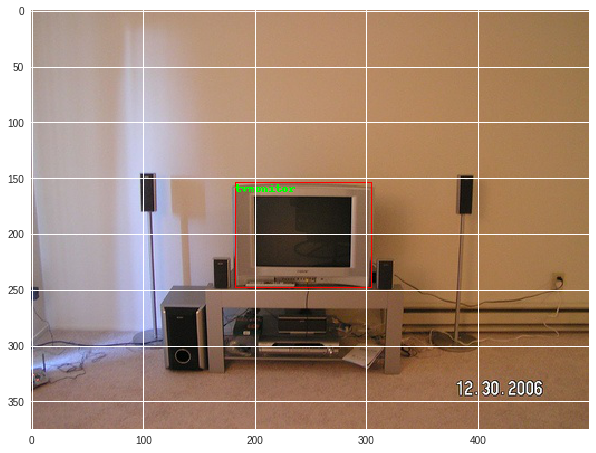

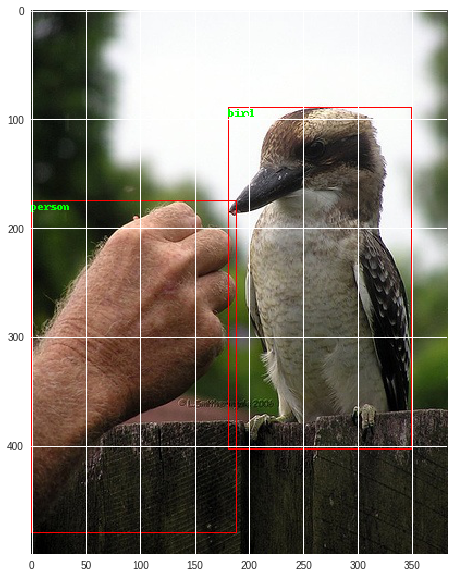

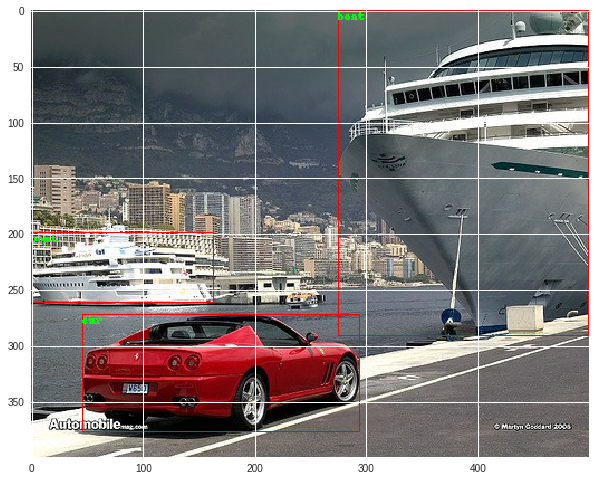

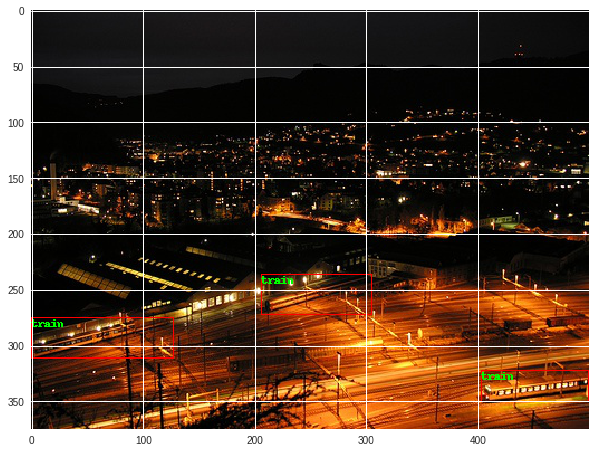

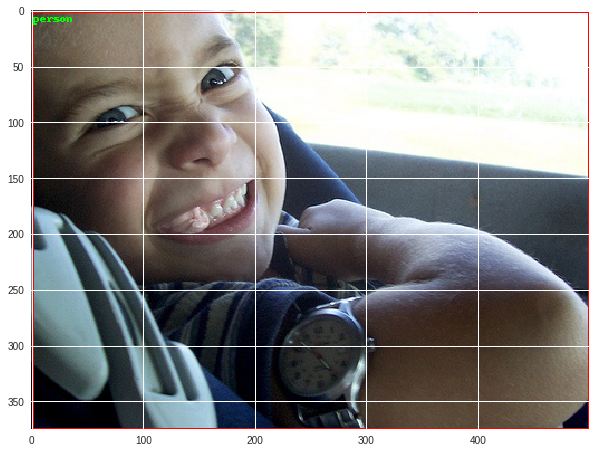

In [0]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('VOCdevkit_2007/VOC2007/', 'JPEGImages', ds_train.names[idx]+'.jpg')
    img = Image.open(_imgpath).convert('RGB')
    draw = ImageDraw.Draw(img)
    for j in range(len(ds_train.box_indices[idx])):
        obj = ds_train.box_indices[idx][j]
        draw.rectangle(list(obj), outline=(255,0,0))
        draw.text(list(obj[0:2]), ds_train.classes[ds_train.label_order[idx][j]], fill=(0,255,0))
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))

# Classification

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=0)


In [0]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=1)

In [0]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #print(images.shape)
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [0]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

## Modifying the network 

The network you are given as is will allow you to reach around 0.15-0.2 mAP. To meet the benchmark for this assignment you will need to improve the network. There are a variety of different approaches you should try:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



In [0]:
classifier = Classifier().to(device)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))

In [0]:
import numpy as np
#arr=np.array([1,1,1,3,1,1,1,1,1,4,1,2,1,1,1,3,3,2,1,2,1])
#weight=torch.from_numpy(arr)
#weight=weight.to(device)

criterion = nn.MultiLabelSoftMarginLoss()
#optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.92)
optimizer =torch.optim.Adam(classifier.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [0]:
# Training the Classifier
NUM_EPOCHS = 160
TEST_FREQUENCY = 20

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        

Starting epoch number 1
Loss for Training on Epoch 1 is 0.38385292887687683
Starting epoch number 2
Loss for Training on Epoch 2 is 0.24156561493873596
Starting epoch number 3
Loss for Training on Epoch 3 is 0.23414763808250427
Starting epoch number 4
Loss for Training on Epoch 4 is 0.22995591163635254
Starting epoch number 5
Loss for Training on Epoch 5 is 0.2261081337928772
Starting epoch number 6
Loss for Training on Epoch 6 is 0.22265003621578217
Starting epoch number 7
Loss for Training on Epoch 7 is 0.21953028440475464
Starting epoch number 8
Loss for Training on Epoch 8 is 0.21649180352687836
Starting epoch number 9
Loss for Training on Epoch 9 is 0.21611854434013367
Starting epoch number 10
Loss for Training on Epoch 10 is 0.21153473854064941
Starting epoch number 11
Loss for Training on Epoch 11 is 0.21422407031059265
Starting epoch number 12
Loss for Training on Epoch 12 is 0.21198274195194244
Starting epoch number 13
Loss for Training on Epoch 13 is 0.20877470076084137
Start

In [0]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_classifier.pth')

In [0]:
print(classifier.state_dict())

In [0]:
from PIL import Image
def register_extension(id, extension): 
    Image.EXTENSION[extension.lower()] = id.upper()
    Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
    Image.register_extensions = register_extensions

In [0]:
model=classifier.state_dict()
import copy
saved_trainer = copy.deepcopy(model)

In [0]:
with open("my_trainer_object.pkl", "wb") as output_file:
    pickle.dump(saved_trainer, output_file)

In [0]:
with open("my_trainer_object.pkl", "rb") as output_file:
    save=pickle.load(output_file)

In [0]:
classifier.load_state_dict(save)

# Evaluate on test set



In [0]:
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

annotation ind  0
annotation ind  10
annotation ind  20
annotation ind  30
annotation ind  40
annotation ind  50
annotation ind  60
annotation ind  70
annotation ind  80
annotation ind  90
annotation ind  100
annotation ind  110
annotation ind  120
annotation ind  130
annotation ind  140
annotation ind  150
annotation ind  160
annotation ind  170
annotation ind  180
annotation ind  190
annotation ind  200
annotation ind  210
annotation ind  220
annotation ind  230
annotation ind  240
annotation ind  250
annotation ind  260
annotation ind  270
annotation ind  280
annotation ind  290
annotation ind  300
annotation ind  310
annotation ind  320
annotation ind  330
annotation ind  340
annotation ind  350
annotation ind  360
annotation ind  370
annotation ind  380
annotation ind  390
annotation ind  400
annotation ind  410
annotation ind  420
annotation ind  430
annotation ind  440
annotation ind  450
annotation ind  460
annotation ind  470
annotation ind  480
annotation ind  490
annotation 

In [0]:
output_submission_csv('my_solution.csv', test_aps)